# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11583
EM converged at iteration 45, llf=-11340, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-11595
EM converged at iteration 45, llf=-11353, convergence criterion=9.8026e-07 < tolerance=1e-06
EM start iterations, llf=-11648
EM converged at iteration 47, llf=-11403, convergence criterion=9.6169e-07 < tolerance=1e-06
EM start iterations, llf=-11655
EM converged at iteration 47, llf=-11410, convergence criterion=9.6199e-07 < tolerance=1e-06
EM start iterations, llf=-11720
EM converged at iteration 46, llf=-11470, convergence criterion=9.749e-07 < tolerance=1e-06
EM start iterations, llf=-11729
EM converged at iteration 46, llf=-11477, convergence criterion=9.698e-07 < tolerance=1e-06
EM start iterations, llf=-11781
EM converged at iteration 46, llf=-11531, convergence criterion=9.9466e-07 < tolerance=1e-06
EM start iterations, llf=-11781
EM converged at iteration 46, llf=-11531, convergence criterion=9.9466e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13228
EM converged at iteration 30, llf=-13042, convergence criterion=9.3002e-07 < tolerance=1e-06
EM start iterations, llf=-13291
EM converged at iteration 29, llf=-13115, convergence criterion=9.8436e-07 < tolerance=1e-06
EM start iterations, llf=-13297
EM converged at iteration 31, llf=-13118, convergence criterion=9.4772e-07 < tolerance=1e-06
EM start iterations, llf=-13351
EM converged at iteration 32, llf=-13167, convergence criterion=9.1489e-07 < tolerance=1e-06
EM start iterations, llf=-13351
EM converged at iteration 32, llf=-13167, convergence criterion=9.1489e-07 < tolerance=1e-06
EM start iterations, llf=-13362
EM converged at iteration 33, llf=-13180, convergence criterion=9.1583e-07 < tolerance=1e-06
EM start iterations, llf=-13413
EM converged at iteration 32, llf=-13233, convergence criterion=9.8754e-07 < tolerance=1e-06
EM start iterations, llf=-13418
EM converged at iteration 33, llf=-13237, convergence criterion=9.3255e-07 < tolerance=1e-06


EM start iterations, llf=-14942
EM converged at iteration 34, llf=-14744, convergence criterion=9.3109e-07 < tolerance=1e-06
EM start iterations, llf=-14942
EM converged at iteration 34, llf=-14744, convergence criterion=9.3109e-07 < tolerance=1e-06
EM start iterations, llf=-14951
EM converged at iteration 34, llf=-14753, convergence criterion=9.2984e-07 < tolerance=1e-06
EM start iterations, llf=-15003
EM converged at iteration 34, llf=-14805, convergence criterion=9.2062e-07 < tolerance=1e-06
EM start iterations, llf=-15013
EM converged at iteration 34, llf=-14816, convergence criterion=9.1131e-07 < tolerance=1e-06
EM start iterations, llf=-15064
EM converged at iteration 33, llf=-14866, convergence criterion=9.8713e-07 < tolerance=1e-06
EM start iterations, llf=-15071
EM converged at iteration 33, llf=-14873, convergence criterion=9.6949e-07 < tolerance=1e-06
EM start iterations, llf=-15118
EM converged at iteration 33, llf=-14918, convergence criterion=9.6119e-07 < tolerance=1e-06


EM start iterations, llf=-16639
EM converged at iteration 32, llf=-16410, convergence criterion=9.2028e-07 < tolerance=1e-06
EM start iterations, llf=-16643
EM converged at iteration 32, llf=-16415, convergence criterion=9.211e-07 < tolerance=1e-06
EM start iterations, llf=-16695
EM converged at iteration 31, llf=-16467, convergence criterion=9.8756e-07 < tolerance=1e-06
EM start iterations, llf=-16702
EM converged at iteration 31, llf=-16473, convergence criterion=9.9516e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM converged at iteration 31, llf=-16530, convergence criterion=9.8798e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM converged at iteration 31, llf=-16530, convergence criterion=9.8798e-07 < tolerance=1e-06
EM start iterations, llf=-16768
EM converged at iteration 31, llf=-16540, convergence criterion=9.7369e-07 < tolerance=1e-06
EM start iterations, llf=-16819
EM converged at iteration 31, llf=-16591, convergence criterion=9.5136e-07 < tolerance=1e-06
E

EM start iterations, llf=-18147
EM converged at iteration 28, llf=-17905, convergence criterion=9.4238e-07 < tolerance=1e-06
EM start iterations, llf=-18204
EM converged at iteration 28, llf=-17961, convergence criterion=9.5168e-07 < tolerance=1e-06
EM start iterations, llf=-18204
EM converged at iteration 28, llf=-17961, convergence criterion=9.5168e-07 < tolerance=1e-06
EM start iterations, llf=-18209
EM converged at iteration 28, llf=-17966, convergence criterion=9.5218e-07 < tolerance=1e-06
EM start iterations, llf=-18260
EM converged at iteration 28, llf=-18016, convergence criterion=9.6831e-07 < tolerance=1e-06
EM start iterations, llf=-18267
EM converged at iteration 28, llf=-18023, convergence criterion=9.6768e-07 < tolerance=1e-06
EM start iterations, llf=-18323
EM converged at iteration 28, llf=-18077, convergence criterion=9.7776e-07 < tolerance=1e-06
EM start iterations, llf=-18331
EM converged at iteration 28, llf=-18085, convergence criterion=9.8018e-07 < tolerance=1e-06


EM start iterations, llf=-12146
EM converged at iteration 67, llf=-11879, convergence criterion=9.8333e-07 < tolerance=1e-06
EM start iterations, llf=-12128
EM converged at iteration 67, llf=-11859, convergence criterion=9.7911e-07 < tolerance=1e-06
EM start iterations, llf=-12190
EM converged at iteration 55, llf=-11936, convergence criterion=9.9864e-07 < tolerance=1e-06
EM start iterations, llf=-12209
EM converged at iteration 55, llf=-11961, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-12245
EM converged at iteration 60, llf=-12018, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-12244
EM converged at iteration 59, llf=-12015, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-12242
EM converged at iteration 46, llf=-12022, convergence criterion=9.7005e-07 < tolerance=1e-06
EM start iterations, llf=-12242
EM converged at iteration 46, llf=-12022, convergence criterion=9.7005e-07 < tolerance=1e-06


EM start iterations, llf=-13772
EM converged at iteration 44, llf=-13577, convergence criterion=9.5983e-07 < tolerance=1e-06
EM start iterations, llf=-13809
EM converged at iteration 42, llf=-13606, convergence criterion=9.9918e-07 < tolerance=1e-06
EM start iterations, llf=-13815
EM converged at iteration 44, llf=-13618, convergence criterion=9.7096e-07 < tolerance=1e-06
EM start iterations, llf=-13861
EM converged at iteration 47, llf=-13673, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-13861
EM converged at iteration 47, llf=-13673, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-13872
EM converged at iteration 47, llf=-13684, convergence criterion=9.8472e-07 < tolerance=1e-06
EM start iterations, llf=-13923
EM converged at iteration 47, llf=-13734, convergence criterion=9.7421e-07 < tolerance=1e-06
EM start iterations, llf=-13930
EM converged at iteration 46, llf=-13740, convergence criterion=9.8409e-07 < tolerance=1e-06


EM start iterations, llf=-15494
EM converged at iteration 41, llf=-15282, convergence criterion=9.6349e-07 < tolerance=1e-06
EM start iterations, llf=-15494
EM converged at iteration 41, llf=-15282, convergence criterion=9.6349e-07 < tolerance=1e-06
EM start iterations, llf=-15502
EM converged at iteration 40, llf=-15289, convergence criterion=9.8901e-07 < tolerance=1e-06
EM start iterations, llf=-15556
EM converged at iteration 40, llf=-15341, convergence criterion=9.9537e-07 < tolerance=1e-06
EM start iterations, llf=-15558
EM converged at iteration 41, llf=-15343, convergence criterion=9.5676e-07 < tolerance=1e-06
EM start iterations, llf=-15612
EM converged at iteration 41, llf=-15397, convergence criterion=9.8392e-07 < tolerance=1e-06
EM start iterations, llf=-15617
EM converged at iteration 41, llf=-15401, convergence criterion=9.7962e-07 < tolerance=1e-06
EM start iterations, llf=-15661
EM converged at iteration 41, llf=-15445, convergence criterion=9.8589e-07 < tolerance=1e-06


EM start iterations, llf=-17193
EM converged at iteration 36, llf=-16967, convergence criterion=9.8403e-07 < tolerance=1e-06
EM start iterations, llf=-17198
EM converged at iteration 36, llf=-16973, convergence criterion=9.8294e-07 < tolerance=1e-06
EM start iterations, llf=-17254
EM converged at iteration 36, llf=-17027, convergence criterion=9.6005e-07 < tolerance=1e-06
EM start iterations, llf=-17262
EM converged at iteration 36, llf=-17034, convergence criterion=9.5719e-07 < tolerance=1e-06
EM start iterations, llf=-17308
EM converged at iteration 35, llf=-17079, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-17308
EM converged at iteration 35, llf=-17079, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-17327
EM converged at iteration 35, llf=-17099, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-17381
EM converged at iteration 35, llf=-17152, convergence criterion=9.5634e-07 < tolerance=1e-06


EM start iterations, llf=-18677
EM converged at iteration 35, llf=-18420, convergence criterion=9.6712e-07 < tolerance=1e-06
EM start iterations, llf=-18726
EM converged at iteration 35, llf=-18470, convergence criterion=9.465e-07 < tolerance=1e-06
EM start iterations, llf=-18726
EM converged at iteration 35, llf=-18470, convergence criterion=9.465e-07 < tolerance=1e-06
EM start iterations, llf=-18733
EM converged at iteration 35, llf=-18479, convergence criterion=9.4507e-07 < tolerance=1e-06
EM start iterations, llf=-18791
EM converged at iteration 35, llf=-18536, convergence criterion=9.4719e-07 < tolerance=1e-06
EM start iterations, llf=-18799
EM converged at iteration 35, llf=-18544, convergence criterion=9.4577e-07 < tolerance=1e-06
EM start iterations, llf=-18851
EM converged at iteration 35, llf=-18594, convergence criterion=9.58e-07 < tolerance=1e-06
EM start iterations, llf=-18859
EM converged at iteration 35, llf=-18603, convergence criterion=9.5696e-07 < tolerance=1e-06
EM s

EM converged at iteration 46, llf=-12342, convergence criterion=9.9385e-07 < tolerance=1e-06
EM start iterations, llf=-12554
EM converged at iteration 46, llf=-12349, convergence criterion=9.9252e-07 < tolerance=1e-06
EM start iterations, llf=-12602
EM converged at iteration 46, llf=-12394, convergence criterion=9.7482e-07 < tolerance=1e-06
EM start iterations, llf=-12609
EM converged at iteration 46, llf=-12402, convergence criterion=9.7736e-07 < tolerance=1e-06
EM start iterations, llf=-12655
EM converged at iteration 45, llf=-12443, convergence criterion=9.6733e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM converged at iteration 45, llf=-12453, convergence criterion=9.5659e-07 < tolerance=1e-06
EM start iterations, llf=-12722
EM converged at iteration 46, llf=-12517, convergence criterion=9.8808e-07 < tolerance=1e-06
EM start iterations, llf=-12722
EM converged at iteration 46, llf=-12517, convergence criterion=9.8808e-07 < tolerance=1e-06
EM start iterations, llf=-12733


EM start iterations, llf=-14279
EM converged at iteration 49, llf=-14087, convergence criterion=9.617e-07 < tolerance=1e-06
EM start iterations, llf=-14336
EM converged at iteration 50, llf=-14147, convergence criterion=9.6238e-07 < tolerance=1e-06
EM start iterations, llf=-14344
EM converged at iteration 49, llf=-14152, convergence criterion=9.8369e-07 < tolerance=1e-06
EM start iterations, llf=-14397
EM converged at iteration 50, llf=-14207, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-14397
EM converged at iteration 50, llf=-14207, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-14405
EM converged at iteration 49, llf=-14213, convergence criterion=9.989e-07 < tolerance=1e-06
EM start iterations, llf=-14460
EM converged at iteration 49, llf=-14267, convergence criterion=9.9043e-07 < tolerance=1e-06
EM start iterations, llf=-14469
EM converged at iteration 48, llf=-14274, convergence criterion=9.9986e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16024
EM converged at iteration 47, llf=-15809, convergence criterion=9.5366e-07 < tolerance=1e-06
EM start iterations, llf=-16024
EM converged at iteration 47, llf=-15809, convergence criterion=9.5366e-07 < tolerance=1e-06
EM start iterations, llf=-16033
EM converged at iteration 47, llf=-15818, convergence criterion=9.5358e-07 < tolerance=1e-06
EM start iterations, llf=-16085
EM converged at iteration 46, llf=-15868, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-16094
EM converged at iteration 46, llf=-15878, convergence criterion=9.836e-07 < tolerance=1e-06
EM start iterations, llf=-16142
EM converged at iteration 46, llf=-15925, convergence criterion=9.6871e-07 < tolerance=1e-06
EM start iterations, llf=-16149
EM converged at iteration 46, llf=-15932, convergence criterion=9.6548e-07 < tolerance=1e-06
EM start iterations, llf=-16201
EM converged at iteration 46, llf=-15983, convergence criterion=9.5935e-07 < tolerance=1e-06
E

EM start iterations, llf=-17726
EM converged at iteration 41, llf=-17493, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-17732
EM converged at iteration 41, llf=-17501, convergence criterion=9.8984e-07 < tolerance=1e-06
EM start iterations, llf=-17783
EM converged at iteration 41, llf=-17550, convergence criterion=9.8149e-07 < tolerance=1e-06
EM start iterations, llf=-17790
EM converged at iteration 41, llf=-17557, convergence criterion=9.82e-07 < tolerance=1e-06
EM start iterations, llf=-17846
EM converged at iteration 41, llf=-17612, convergence criterion=9.9357e-07 < tolerance=1e-06
EM start iterations, llf=-17846
EM converged at iteration 41, llf=-17612, convergence criterion=9.9357e-07 < tolerance=1e-06
EM start iterations, llf=-17850
EM converged at iteration 41, llf=-17614, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-17903
EM converged at iteration 41, llf=-17666, convergence criterion=9.8663e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18924
EM converged at iteration 41, llf=-18664, convergence criterion=9.9525e-07 < tolerance=1e-06
EM start iterations, llf=-18980
EM converged at iteration 42, llf=-18720, convergence criterion=9.4949e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:40:16.637522.
EM start iterations, llf=-11103
EM converged at iteration 45, llf=-10958, convergence criterion=9.7243e-07 < tolerance=1e-06
EM start iterations, llf=-11116
EM converged at iteration 45, llf=-10971, convergence criterion=9.7419e-07 < tolerance=1e-06
EM start iterations, llf=-11168
EM converged at iteration 46, llf=-11023, convergence criterion=9.959e-07 < tolerance=1e-06
EM start iterations, llf=-11176
EM converged at iteration 46, llf=-11031, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-11234
EM converged at iteration 44, llf=-11090, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-11245
EM converged at i

EM converged at iteration 31, llf=-12369, convergence criterion=9.4337e-07 < tolerance=1e-06
EM start iterations, llf=-12524
EM converged at iteration 31, llf=-12381, convergence criterion=9.4851e-07 < tolerance=1e-06
EM start iterations, llf=-12558
EM converged at iteration 31, llf=-12415, convergence criterion=9.5409e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 31, llf=-12418, convergence criterion=9.665e-07 < tolerance=1e-06
EM start iterations, llf=-12624
EM converged at iteration 31, llf=-12472, convergence criterion=9.6322e-07 < tolerance=1e-06
EM start iterations, llf=-12629
EM converged at iteration 31, llf=-12480, convergence criterion=9.5111e-07 < tolerance=1e-06
EM start iterations, llf=-12673
EM converged at iteration 30, llf=-12523, convergence criterion=9.7576e-07 < tolerance=1e-06
EM start iterations, llf=-12673
EM converged at iteration 30, llf=-12523, convergence criterion=9.7576e-07 < tolerance=1e-06
EM start iterations, llf=-12678
E

EM start iterations, llf=-14101
EM converged at iteration 29, llf=-13944, convergence criterion=9.6223e-07 < tolerance=1e-06
EM start iterations, llf=-14152
EM converged at iteration 29, llf=-13995, convergence criterion=9.6603e-07 < tolerance=1e-06
EM start iterations, llf=-14160
EM converged at iteration 29, llf=-14003, convergence criterion=9.6456e-07 < tolerance=1e-06
EM start iterations, llf=-14210
EM converged at iteration 29, llf=-14053, convergence criterion=9.3647e-07 < tolerance=1e-06
EM start iterations, llf=-14210
EM converged at iteration 29, llf=-14053, convergence criterion=9.3647e-07 < tolerance=1e-06
EM start iterations, llf=-14217
EM converged at iteration 29, llf=-14061, convergence criterion=9.3987e-07 < tolerance=1e-06
EM start iterations, llf=-14267
EM converged at iteration 28, llf=-14110, convergence criterion=9.9439e-07 < tolerance=1e-06
EM start iterations, llf=-14274
EM converged at iteration 28, llf=-14118, convergence criterion=9.8839e-07 < tolerance=1e-06


EM start iterations, llf=-15779
EM converged at iteration 28, llf=-15616, convergence criterion=9.4904e-07 < tolerance=1e-06
EM start iterations, llf=-15779
EM converged at iteration 28, llf=-15616, convergence criterion=9.4904e-07 < tolerance=1e-06
EM start iterations, llf=-15793
EM converged at iteration 28, llf=-15629, convergence criterion=9.4478e-07 < tolerance=1e-06
EM start iterations, llf=-15850
EM converged at iteration 28, llf=-15688, convergence criterion=9.5569e-07 < tolerance=1e-06
EM start iterations, llf=-15853
EM converged at iteration 28, llf=-15691, convergence criterion=9.6729e-07 < tolerance=1e-06
EM start iterations, llf=-15904
EM converged at iteration 28, llf=-15742, convergence criterion=9.4571e-07 < tolerance=1e-06
EM start iterations, llf=-15910
EM converged at iteration 28, llf=-15749, convergence criterion=9.4659e-07 < tolerance=1e-06
EM start iterations, llf=-15963
EM converged at iteration 28, llf=-15802, convergence criterion=9.5772e-07 < tolerance=1e-06


EM start iterations, llf=-17219
EM converged at iteration 27, llf=-17051, convergence criterion=9.6321e-07 < tolerance=1e-06
EM start iterations, llf=-17233
EM converged at iteration 27, llf=-17065, convergence criterion=9.5676e-07 < tolerance=1e-06
EM start iterations, llf=-17287
EM converged at iteration 26, llf=-17118, convergence criterion=9.96e-07 < tolerance=1e-06
EM start iterations, llf=-17293
EM converged at iteration 26, llf=-17124, convergence criterion=9.9629e-07 < tolerance=1e-06
EM start iterations, llf=-17347
EM converged at iteration 26, llf=-17178, convergence criterion=9.8865e-07 < tolerance=1e-06
EM start iterations, llf=-17347
EM converged at iteration 26, llf=-17178, convergence criterion=9.8865e-07 < tolerance=1e-06
EM start iterations, llf=-17352
EM converged at iteration 26, llf=-17183, convergence criterion=9.9385e-07 < tolerance=1e-06
EM start iterations, llf=-17399
EM converged at iteration 26, llf=-17230, convergence criterion=9.8334e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11557
EM converged at iteration 80, llf=-11407, convergence criterion=9.9462e-07 < tolerance=1e-06
EM start iterations, llf=-11560
EM converged at iteration 79, llf=-11409, convergence criterion=9.9994e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM converged at iteration 77, llf=-11481, convergence criterion=9.9766e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM converged at iteration 77, llf=-11481, convergence criterion=9.9766e-07 < tolerance=1e-06
EM start iterations, llf=-11642
EM converged at iteration 78, llf=-11494, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-11717
EM converged at iteration 65, llf=-11577, convergence criterion=9.8754e-07 < tolerance=1e-06
EM start iterations, llf=-11704
EM converged at iteration 67, llf=-11563, convergence criterion=9.9794e-07 < tolerance=1e-06
EM start iterations, llf=-11694
EM converged at iteration 69, llf=-11546, convergence criterion=9.9722e-07 < tolerance=1e-06


EM start iterations, llf=-13014
EM converged at iteration 38, llf=-12857, convergence criterion=9.9619e-07 < tolerance=1e-06
EM start iterations, llf=-13022
EM converged at iteration 38, llf=-12868, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-13066
EM converged at iteration 39, llf=-12911, convergence criterion=9.8934e-07 < tolerance=1e-06
EM start iterations, llf=-13075
EM converged at iteration 40, llf=-12920, convergence criterion=9.843e-07 < tolerance=1e-06
EM start iterations, llf=-13119
EM converged at iteration 40, llf=-12963, convergence criterion=9.9142e-07 < tolerance=1e-06
EM start iterations, llf=-13111
EM converged at iteration 39, llf=-12960, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-13153
EM converged at iteration 39, llf=-13000, convergence criterion=9.7286e-07 < tolerance=1e-06
EM start iterations, llf=-13153
EM converged at iteration 39, llf=-13000, convergence criterion=9.7286e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14628
EM converged at iteration 31, llf=-14470, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-14680
EM converged at iteration 32, llf=-14523, convergence criterion=9.6636e-07 < tolerance=1e-06
EM start iterations, llf=-14687
EM converged at iteration 32, llf=-14529, convergence criterion=9.6882e-07 < tolerance=1e-06
EM start iterations, llf=-14732
EM converged at iteration 31, llf=-14576, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-14732
EM converged at iteration 31, llf=-14576, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-14745
EM converged at iteration 31, llf=-14588, convergence criterion=9.6522e-07 < tolerance=1e-06
EM start iterations, llf=-14800
EM converged at iteration 31, llf=-14642, convergence criterion=9.8488e-07 < tolerance=1e-06
EM start iterations, llf=-14800
EM converged at iteration 31, llf=-14643, convergence criterion=9.9317e-07 < tolerance=1e-06
E

EM start iterations, llf=-16307
EM converged at iteration 28, llf=-16141, convergence criterion=9.8866e-07 < tolerance=1e-06
EM start iterations, llf=-16307
EM converged at iteration 28, llf=-16141, convergence criterion=9.8866e-07 < tolerance=1e-06
EM start iterations, llf=-16316
EM converged at iteration 28, llf=-16149, convergence criterion=9.8767e-07 < tolerance=1e-06
EM start iterations, llf=-16363
EM converged at iteration 28, llf=-16195, convergence criterion=9.9728e-07 < tolerance=1e-06
EM start iterations, llf=-16367
EM converged at iteration 28, llf=-16200, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-16422
EM converged at iteration 28, llf=-16255, convergence criterion=9.6455e-07 < tolerance=1e-06
EM start iterations, llf=-16431
EM converged at iteration 28, llf=-16264, convergence criterion=9.7489e-07 < tolerance=1e-06
EM start iterations, llf=-16473
EM converged at iteration 28, llf=-16307, convergence criterion=9.5965e-07 < tolerance=1e-06


EM start iterations, llf=-17735
EM converged at iteration 28, llf=-17563, convergence criterion=9.8964e-07 < tolerance=1e-06
EM start iterations, llf=-17742
EM converged at iteration 28, llf=-17570, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-17788
EM converged at iteration 28, llf=-17616, convergence criterion=9.6273e-07 < tolerance=1e-06
EM start iterations, llf=-17795
EM converged at iteration 28, llf=-17623, convergence criterion=9.5727e-07 < tolerance=1e-06
EM start iterations, llf=-17840
EM converged at iteration 28, llf=-17667, convergence criterion=9.5552e-07 < tolerance=1e-06
EM start iterations, llf=-17840
EM converged at iteration 28, llf=-17667, convergence criterion=9.5552e-07 < tolerance=1e-06
EM start iterations, llf=-17845
EM converged at iteration 28, llf=-17672, convergence criterion=9.5962e-07 < tolerance=1e-06
EM start iterations, llf=-17901
EM converged at iteration 28, llf=-17727, convergence criterion=9.62e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11890
EM converged at iteration 53, llf=-11744, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-11906
EM converged at iteration 52, llf=-11755, convergence criterion=9.8091e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM converged at iteration 53, llf=-11811, convergence criterion=9.9045e-07 < tolerance=1e-06
EM start iterations, llf=-11961
EM converged at iteration 53, llf=-11811, convergence criterion=9.9045e-07 < tolerance=1e-06
EM start iterations, llf=-11962
EM converged at iteration 56, llf=-11815, convergence criterion=9.8868e-07 < tolerance=1e-06
EM start iterations, llf=-12001
EM converged at iteration 59, llf=-11856, convergence criterion=9.8377e-07 < tolerance=1e-06
EM start iterations, llf=-12011
EM converged at iteration 57, llf=-11865, convergence criterion=9.8263e-07 < tolerance=1e-06
EM start iterations, llf=-12058
EM converged at iteration 60, llf=-11915, convergence criterion=9.8059e-07 < tolerance=1e-06


EM start iterations, llf=-13489
EM converged at iteration 56, llf=-13335, convergence criterion=9.9537e-07 < tolerance=1e-06
EM start iterations, llf=-13495
EM converged at iteration 56, llf=-13340, convergence criterion=9.9566e-07 < tolerance=1e-06
EM start iterations, llf=-13557
EM converged at iteration 54, llf=-13402, convergence criterion=9.8863e-07 < tolerance=1e-06
EM start iterations, llf=-13563
EM converged at iteration 53, llf=-13408, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-13615
EM converged at iteration 53, llf=-13461, convergence criterion=9.9905e-07 < tolerance=1e-06
EM start iterations, llf=-13624
EM converged at iteration 53, llf=-13470, convergence criterion=9.7302e-07 < tolerance=1e-06
EM start iterations, llf=-13676
EM converged at iteration 51, llf=-13520, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-13676
EM converged at iteration 51, llf=-13520, convergence criterion=9.8613e-07 < tolerance=1e-06


EM start iterations, llf=-15138
EM converged at iteration 48, llf=-14980, convergence criterion=9.7152e-07 < tolerance=1e-06
EM start iterations, llf=-15193
EM converged at iteration 48, llf=-15033, convergence criterion=9.729e-07 < tolerance=1e-06
EM start iterations, llf=-15198
EM converged at iteration 48, llf=-15038, convergence criterion=9.7669e-07 < tolerance=1e-06
EM start iterations, llf=-15253
EM converged at iteration 48, llf=-15093, convergence criterion=9.8964e-07 < tolerance=1e-06
EM start iterations, llf=-15253
EM converged at iteration 48, llf=-15093, convergence criterion=9.8964e-07 < tolerance=1e-06
EM start iterations, llf=-15263
EM converged at iteration 48, llf=-15103, convergence criterion=9.824e-07 < tolerance=1e-06
EM start iterations, llf=-15312
EM converged at iteration 48, llf=-15152, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-15321
EM converged at iteration 48, llf=-15161, convergence criterion=9.7107e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16831
EM converged at iteration 51, llf=-16663, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-16831
EM converged at iteration 51, llf=-16663, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-16838
EM converged at iteration 51, llf=-16670, convergence criterion=9.8745e-07 < tolerance=1e-06
EM start iterations, llf=-16887
EM converged at iteration 50, llf=-16719, convergence criterion=9.7818e-07 < tolerance=1e-06
EM start iterations, llf=-16894
EM converged at iteration 50, llf=-16725, convergence criterion=9.7414e-07 < tolerance=1e-06
EM start iterations, llf=-16943
EM converged at iteration 50, llf=-16774, convergence criterion=9.8272e-07 < tolerance=1e-06
EM start iterations, llf=-16951
EM converged at iteration 50, llf=-16781, convergence criterion=9.8887e-07 < tolerance=1e-06
EM start iterations, llf=-17004
EM converged at iteration 50, llf=-16834, convergence criterion=9.7575e-07 < tolerance=1e-06


EM start iterations, llf=-17950
EM converged at iteration 46, llf=-17783, convergence criterion=9.696e-07 < tolerance=1e-06
EM start iterations, llf=-17961
EM converged at iteration 45, llf=-17794, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-18018
EM converged at iteration 46, llf=-17850, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-18022
EM converged at iteration 46, llf=-17854, convergence criterion=9.9215e-07 < tolerance=1e-06
EM start iterations, llf=-18077
EM converged at iteration 46, llf=-17908, convergence criterion=9.8594e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:12:32.124372.
Overall time taken for running all models: 9:26:54.753654.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


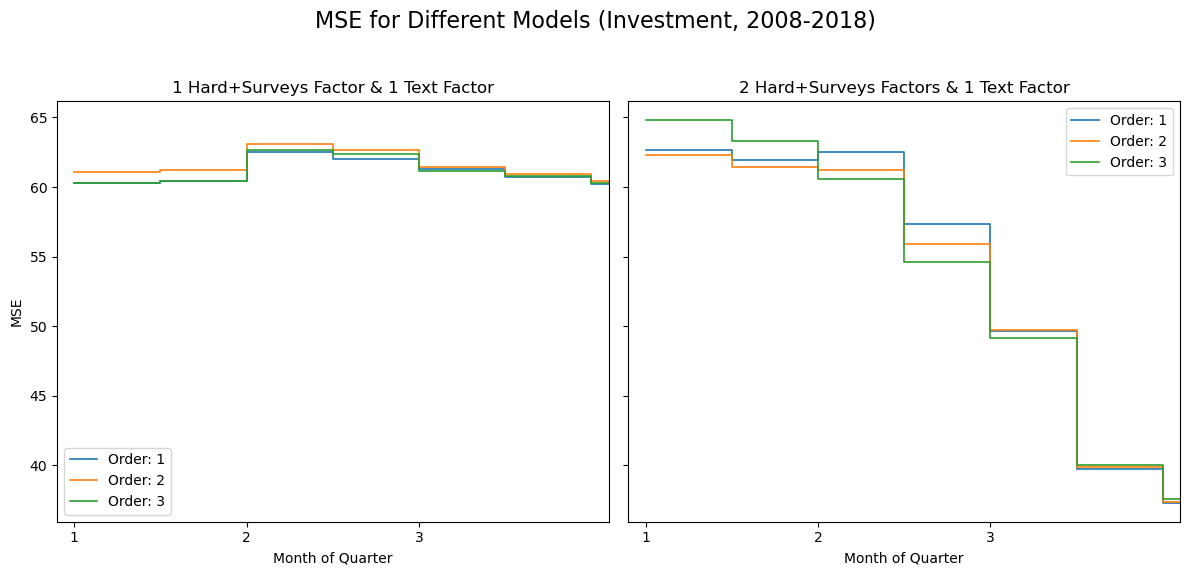

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


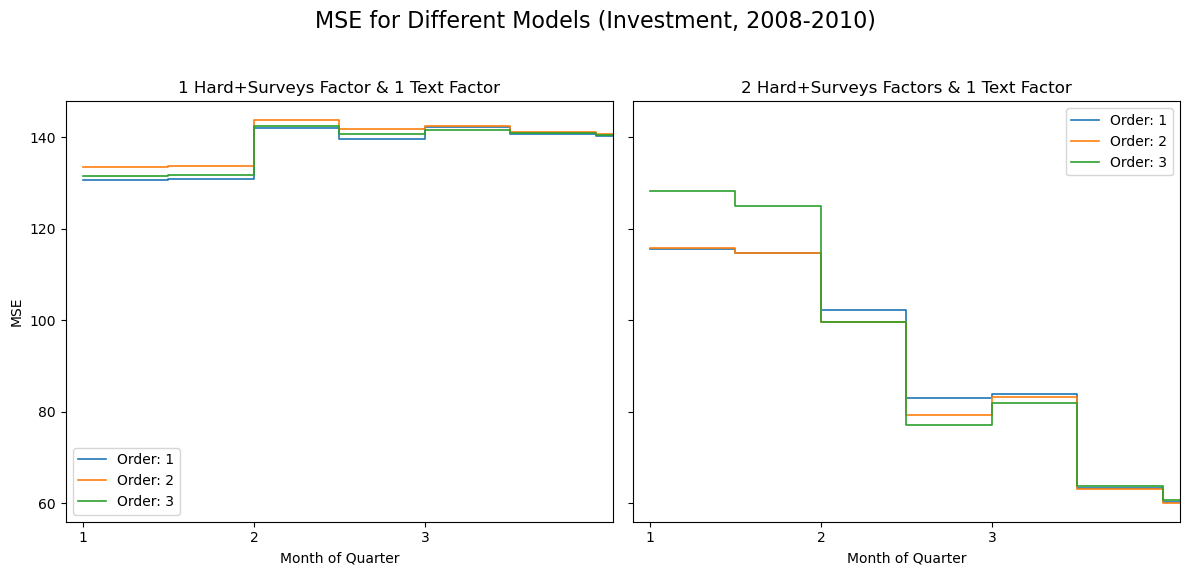

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


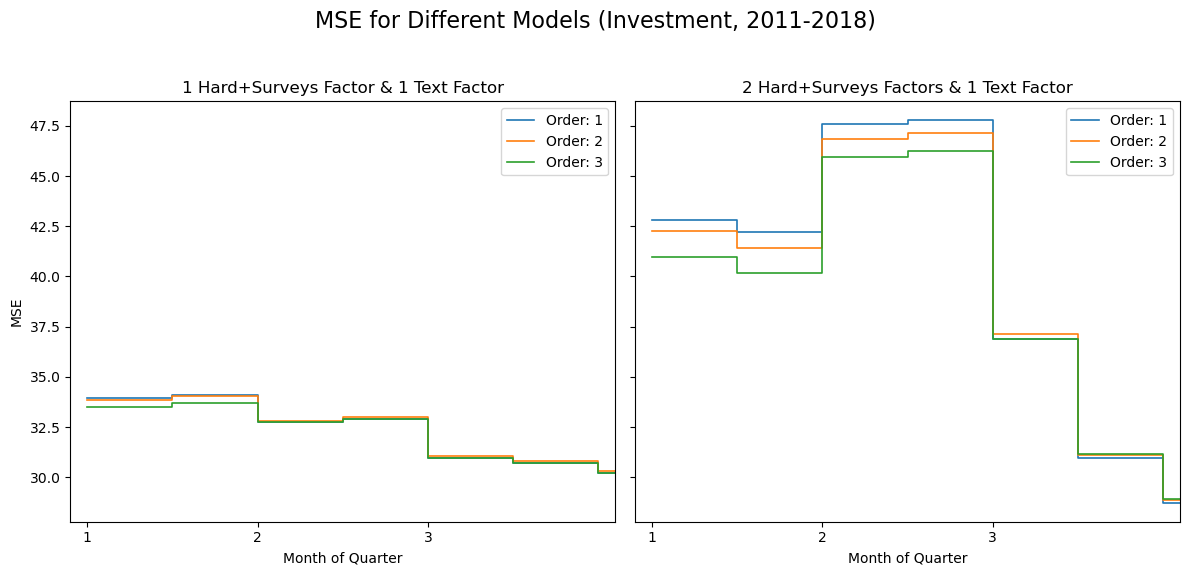

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


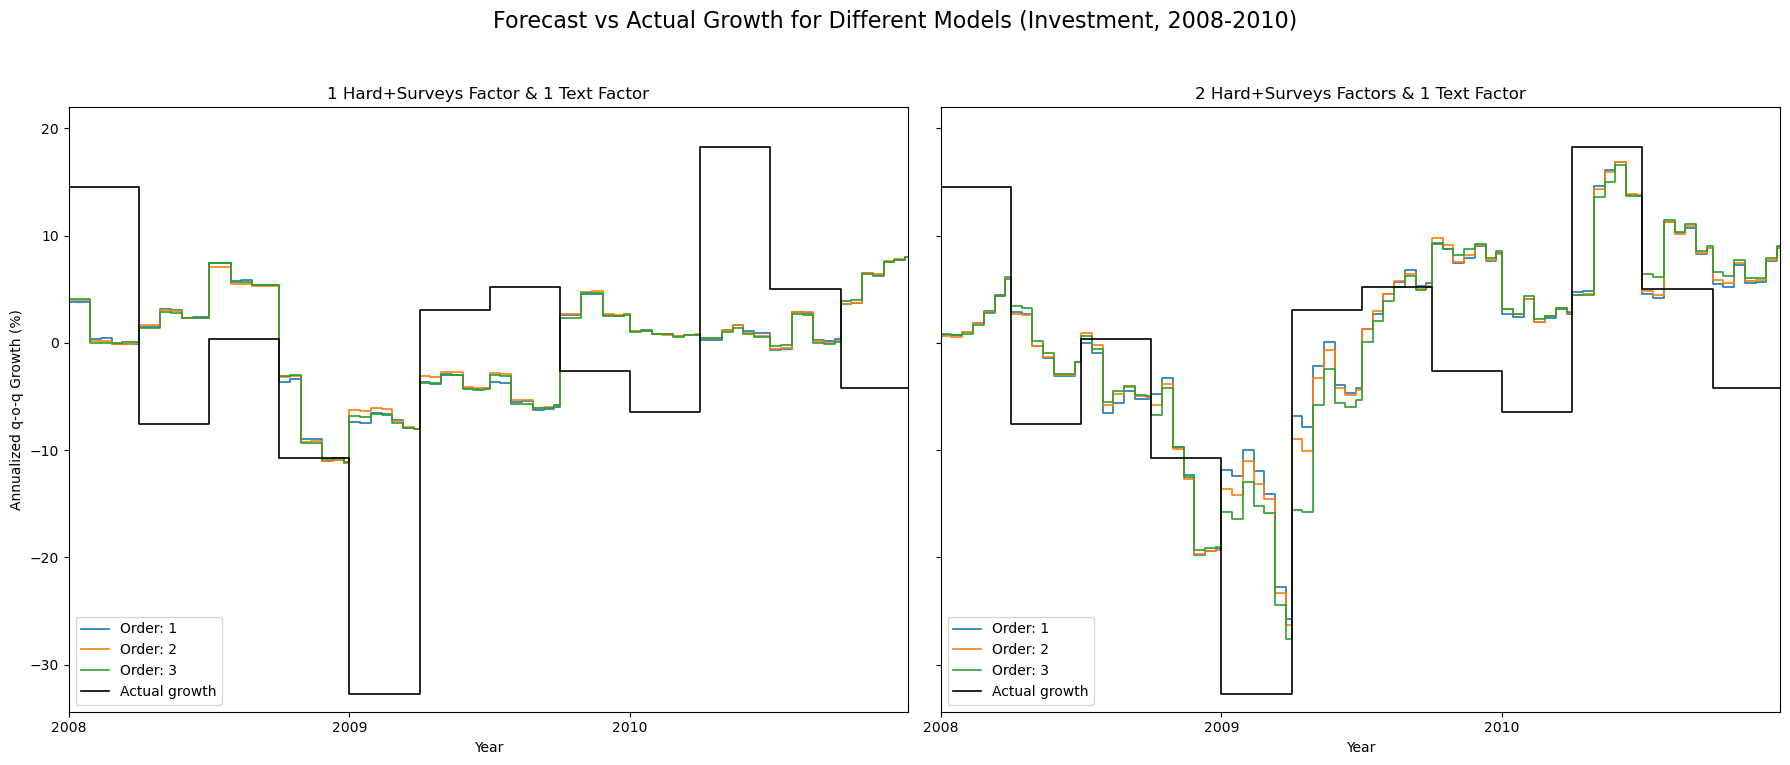

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


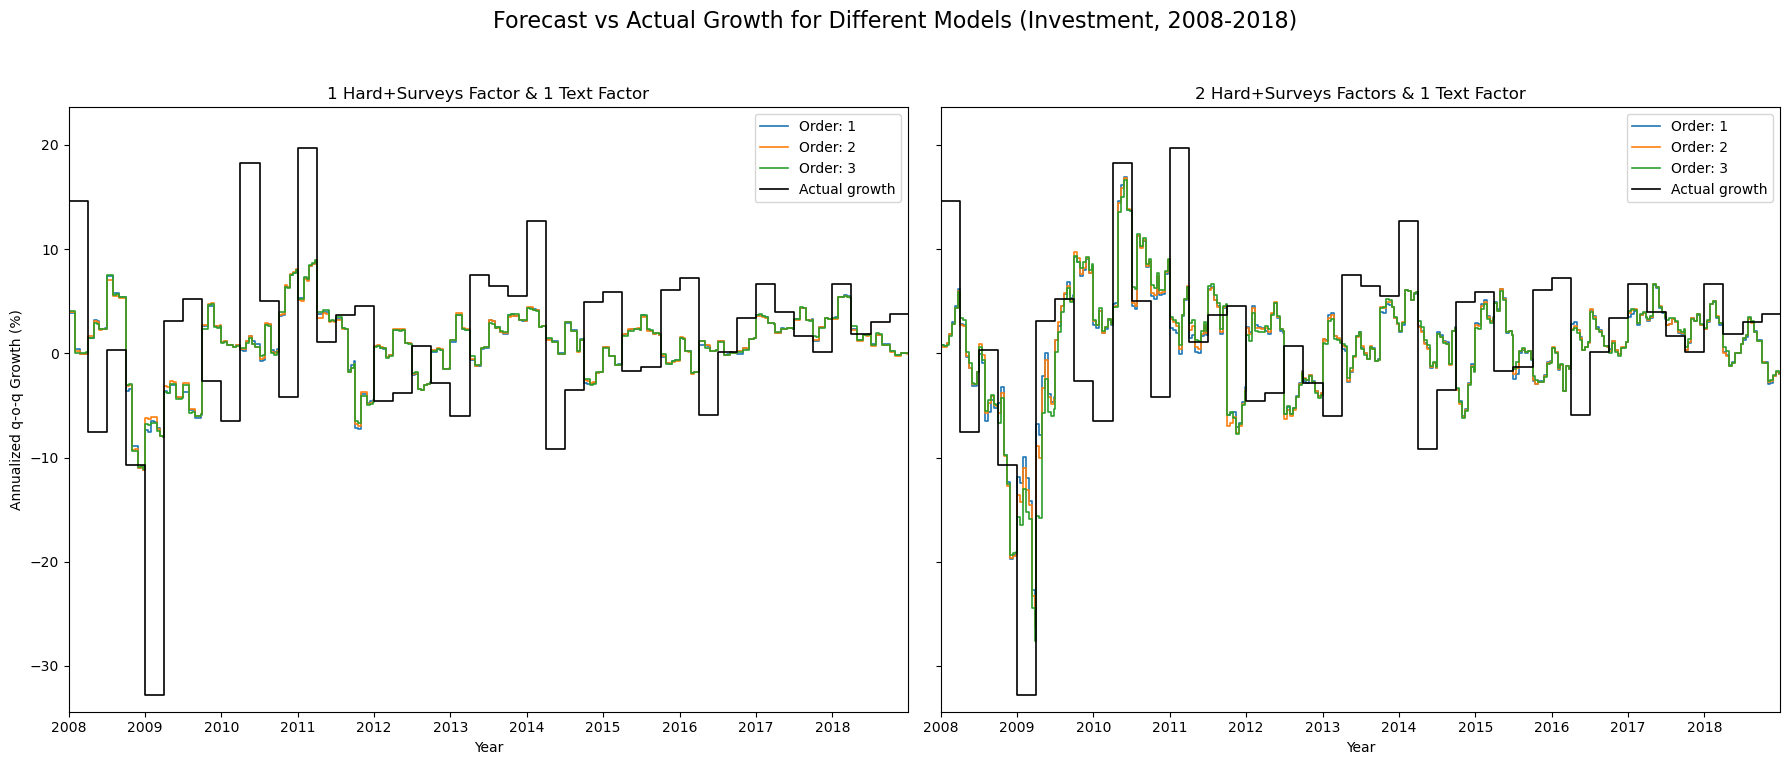

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


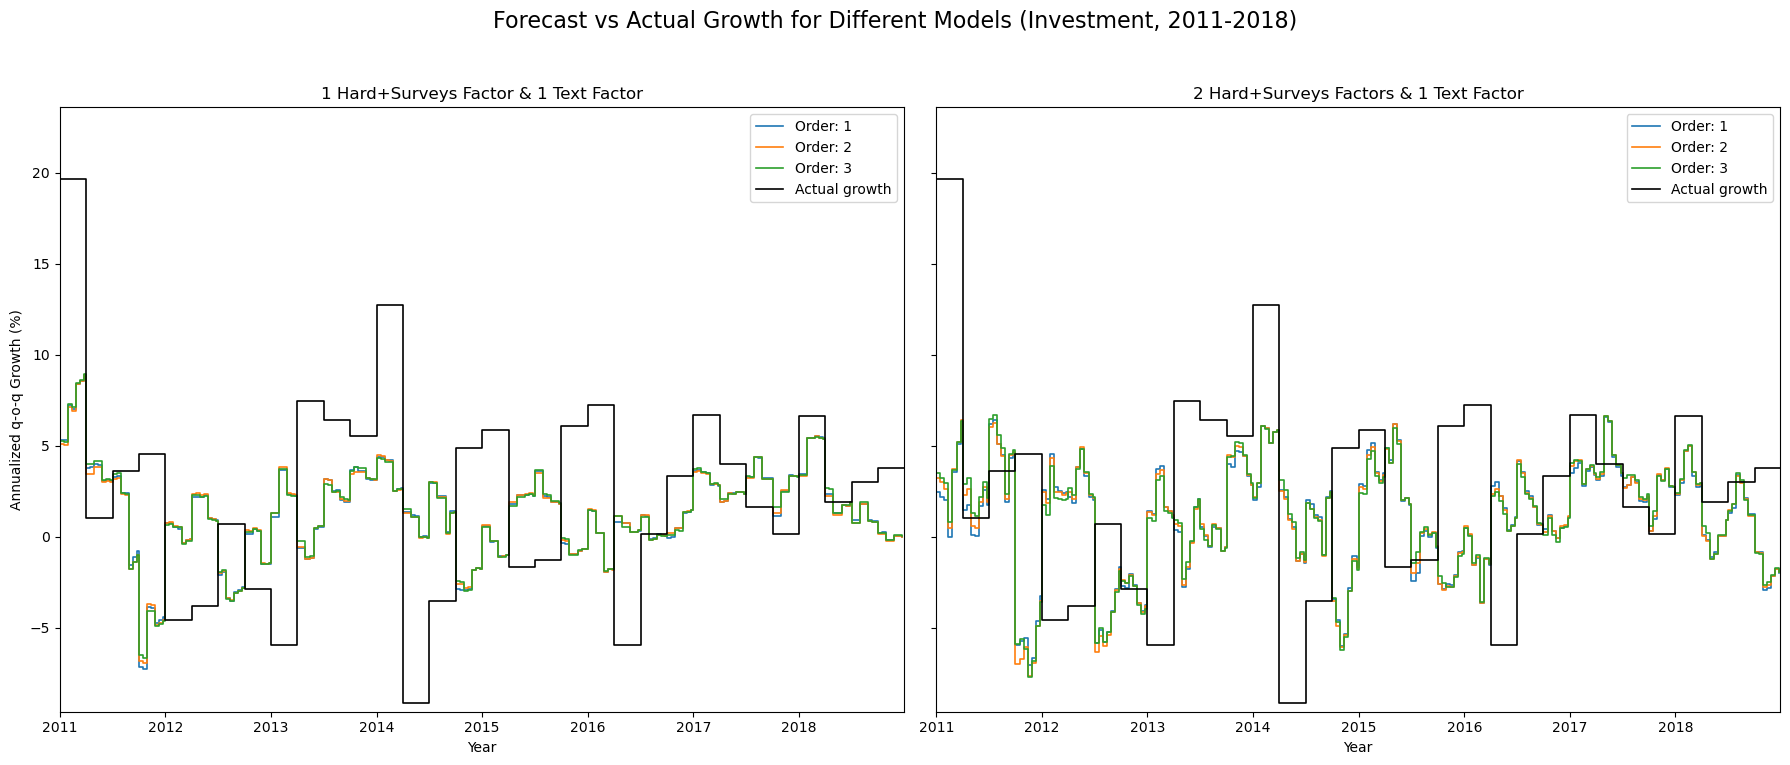

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()